# Loan Payoff Classification Model Benchmark

*Benchmark for building and evaluating the best Machine Learning classification model for predicting whether a loan will be paid off or not*

## 1. Data Collection

**V1:** The dataset selected for this exercise is provided by the course material. In this dataset, each record represents a loan application which contains attributes of the loan applicant and details about the application itself, including dates, amount, and payoff status.

In this project, **IBM Watson Studio** is being utilized as the platform to manage the environment and data connections for developing machine learning models for the data. The following set of code is populated by Watson Studio to access the dataset stored on the **IBM Cloud Object Storage**.

In [126]:
# The code was removed by Watson Studio for sharing.

## 2. Data Understanding

Now that the dataset has been retreived from the cloud storage, it is ready for analysis and cleaning

In [127]:
# Import libraries for exploratory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
# Read in data into a dataframe
loans = pd.read_csv(body)

# Preview dataframe
loans.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


**Observation:** After the dataset was transformed into a dataframe, a few transofrmations were made to the column titles. The column titled *Unnamed: 0* appears to be an additional index column in the original file, and the original index column of the dataset, which had no column header, was named as *Unnamed: 0.1*. Pandas automatically added a numeric index column when the dataframe was initialized.

### Null Values and Data Types

In [146]:
# Inspect data types and null values
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   loan_status        346 non-null    object        
 1   Principal          346 non-null    int64         
 2   terms              346 non-null    int64         
 3   effective_date     346 non-null    datetime64[ns]
 4   due_date           346 non-null    datetime64[ns]
 5   age                346 non-null    int64         
 6   education          346 non-null    int64         
 7   days_to_start      346 non-null    int64         
 8   female             346 non-null    uint8         
 9   male               346 non-null    uint8         
 10  monthly_principal  346 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(5), object(1), uint8(2)
memory usage: 25.1+ KB


**Observation:** This dataset has no missing values in any of the features and consists of a variety of data types: numeric, categorical, and datetime. 

### Datetime Field Relationships

In [147]:
# Convert object type to datetime
loans['due_date'] = pd.to_datetime(loans['due_date'])
loans['effective_date'] = pd.to_datetime(loans['effective_date'])

# Create feature that represent the number of days between the loan application is due and when it is effective
loans['days_to_start'] = (loans['due_date'] - loans['effective_date']).dt.days + 1 # Add one since the date is inclusive

In [148]:
# Inspect after data type transformation
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   loan_status        346 non-null    object        
 1   Principal          346 non-null    int64         
 2   terms              346 non-null    int64         
 3   effective_date     346 non-null    datetime64[ns]
 4   due_date           346 non-null    datetime64[ns]
 5   age                346 non-null    int64         
 6   education          346 non-null    int64         
 7   days_to_start      346 non-null    int64         
 8   female             346 non-null    uint8         
 9   male               346 non-null    uint8         
 10  monthly_principal  346 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(5), object(1), uint8(2)
memory usage: 25.1+ KB


In [149]:
# Inspect range of datetime values
loans['effective_date'].value_counts().sort_index()

2016-09-08      3
2016-09-09      8
2016-09-10     31
2016-09-11    166
2016-09-12     87
2016-09-13     20
2016-09-14     31
Name: effective_date, dtype: int64

In [150]:
loans['due_date'].value_counts().sort_index()

2016-09-16     3
2016-09-17     2
2016-09-18     3
2016-09-19     3
2016-09-22     1
2016-09-23     3
2016-09-24    12
2016-09-25    63
2016-09-26    42
2016-09-27    11
2016-09-28    10
2016-10-07     2
2016-10-08     5
2016-10-09    18
2016-10-10    90
2016-10-11    36
2016-10-12     6
2016-10-13    19
2016-10-25     4
2016-10-26     1
2016-11-09     6
2016-11-10     4
2016-11-12     2
Name: due_date, dtype: int64

In [151]:
loans['days_to_start'].value_counts().sort_index()

7      11
14      3
15    139
30    176
45      5
60     12
Name: days_to_start, dtype: int64

**Observations**
* All loan applications in the dataset consist of loans that were processed within the span of a week
* Of the loans made effective in that week, the due dates of these loans begin at different time intervals: 1 week, 2 weeks, half a month, a month, one and a half months, or two months - with most falling into 

### Categorical Field Values

In [152]:
# Inspect distinct values
loans['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [153]:
loans['Gender'].value_counts()

KeyError: 'Gender'

In [154]:
loans['education'].value_counts()

1    151
2    149
3     44
4      2
Name: education, dtype: int64

**Observations**
* The *education* attribute can be transformed to a numeric field that can range from 1 to 4, representing the levels of education in the loan applicants - since this data exhibits hierarchy due to the nature of levels in education, this is an appropriate transformation
    * **Assumption:** The value *'college'* implies some college education but not enough for a full degree program
* *loan_status* will serve as the target for the models, as this is what we want to predict 

In [138]:
# Convert gender to numerical features
gender_split = pd.get_dummies(loans['Gender'])
loans.drop(['Gender'],axis=1,inplace=True)
loans = loans.join(gender_split)

In [139]:
# Define dictionary for value mapping
education_dict = {'High School or Below':1,
                  'college':2,
                  'Bechalor':3,
                  'Master or Above':4
                 }

# Apply transformation to education field
loans['education'] = loans['education'].map(education_dict)

In [141]:
# Inspect dataframe with new features
loans.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,days_to_start,female,male
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,1,30,0,1
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,3,30,1,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,2,15,0,1
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,2,30,1,0
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,2,30,0,1


### Numeric Field Distributions

In this section, the numeric fields of the dataset will be inspected by calculating summary statistics and plotting values to spot any outliers, anomalies, and find any relationships that may exist amongst the features.

In [155]:
# Create feature of relationship between principal and term
loans['monthly_principal'] = loans['Principal']/loans['terms']

In [156]:
# Inspect statistics of numeric fields
loans.describe()

,Principal,terms,age,education,days_to_start,female,male,monthly_principal
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,943.641618,22.653179,30.939306,1.702312,24.361272,0.150289,0.849711,47.723644
std,109.425530,7.991006,6.039418,0.706775,10.602958,0.357872,0.357872,20.954252
min,300.000000,7.000000,18.000000,1.000000,7.000000,0.000000,0.000000,26.666667
25%,900.000000,15.000000,27.000000,1.000000,15.000000,0.000000,1.000000,33.333333
50%,1000.000000,30.000000,30.000000,2.000000,30.000000,0.000000,1.000000,33.333333
75%,1000.000000,30.000000,35.000000,2.000000,30.000000,0.000000,1.000000,53.333333
max,1000.000000,30.000000,51.000000,4.000000,60.000000,1.000000,1.000000,142.857143


**Observations**
* *Unnamed: 0* and *Unnamed: 0.1* display the same statistics - which confirms that the columns contain the same values
* *Unnamed: 0* and *Unnamed: 0.1* features have a count of 346 records but a rnage of values from 0 to 399
    * This implies that some records have been previously removed from the dataset
    * Assuming these were index columns, it can be deduced that the original dataset had 400 records and 54 records were removed
* *Principal* appears to have a right skewed distribution, where only a handful of records have small principal amounts and the rest of the loans consist of principal amounts between 900 and 1000 (assuming this is in USD)
    * With the second, third, and fourth quartile values equal to 1000, it appears that there may be a loan application, or grant, limit of 1000
* *terms* appears to be the number of months of repayment in the lifetime of the loan, with most loans having 30 months
    * Terms also appear to be proportional to the amount of principal granted in the loan
* *age* consists of applicants from young adults to middle aged adults, with most applicants ranging between 18 and 35 years old

In [157]:
# Drop unneeded columns
loans.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

KeyError: "['Unnamed: 0' 'Unnamed: 0.1'] not found in axis"

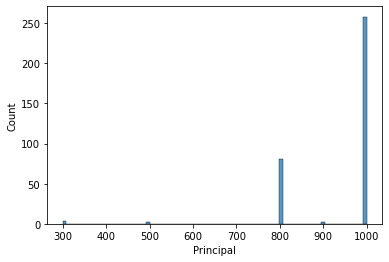

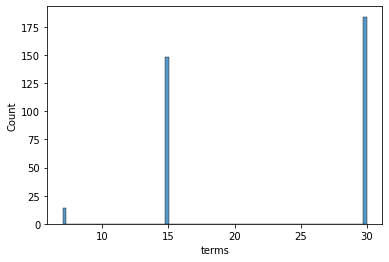

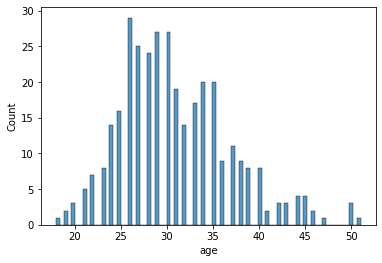

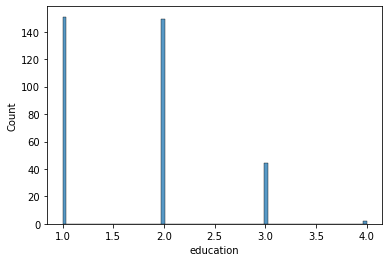

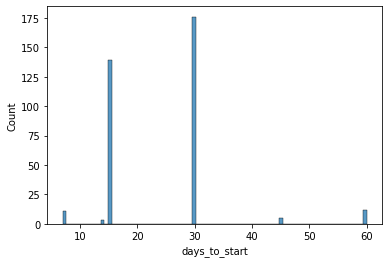

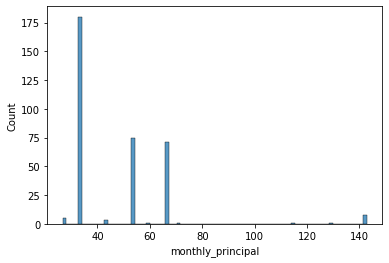

In [158]:
# Display distribution of numeric feature values
for col in loans.columns:
    if loans[col].dtype == 'int64' or loans[col].dtype == 'float64':
        sns.histplot(loans[col],bins=80)
        plt.show()

**Observations**
* The number of loans with a principal of 1000 is much greater than the number of loans with a term of 30 months - there appears to be a factor that allows for an applicant to have a shorter time to payoff the loan than others for the same principal amount
* There appears to be some outliers in the distribution of age of the applicants - further inspection is needed to determine if these are indeed outliers and if they should be kept or excluded 

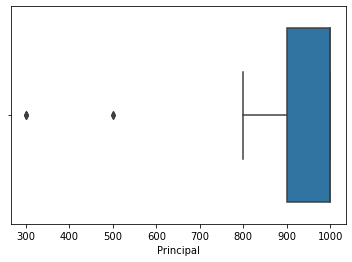

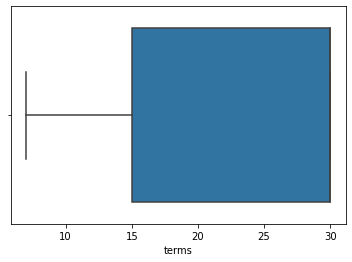

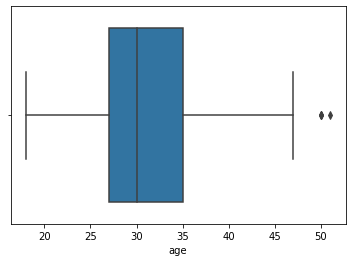

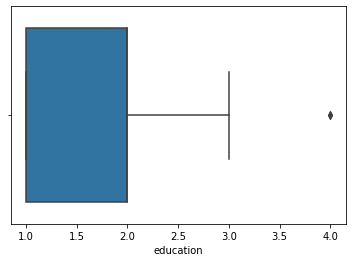

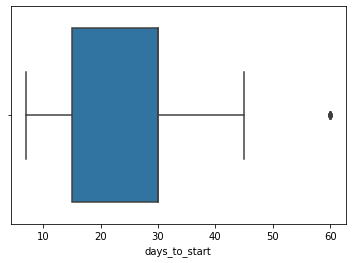

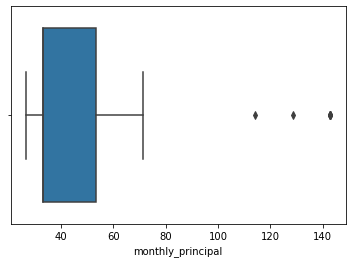

In [117]:
# Display distribution of numeric feature values
for col in loans.columns:
    if loans[col].dtype == 'int64' or loans[col].dtype == 'float64':
        sns.boxplot(x=loans[col])
        plt.show()

The records with loan prinicipal amounts less than 800 consist of only a few samples with values that are indeed at extremes in relation to the other principal amounts and are outliers. While they are outliers, they could still be included in the dataset since we wiil be feeding this data to classification algorithms, which have the capability of treating these samples accordingly - whether it be creating a separate grouping for them or a specific branch of a decision tree. Since this is a small dataset, it is important to keep as many records intact to best train the models.

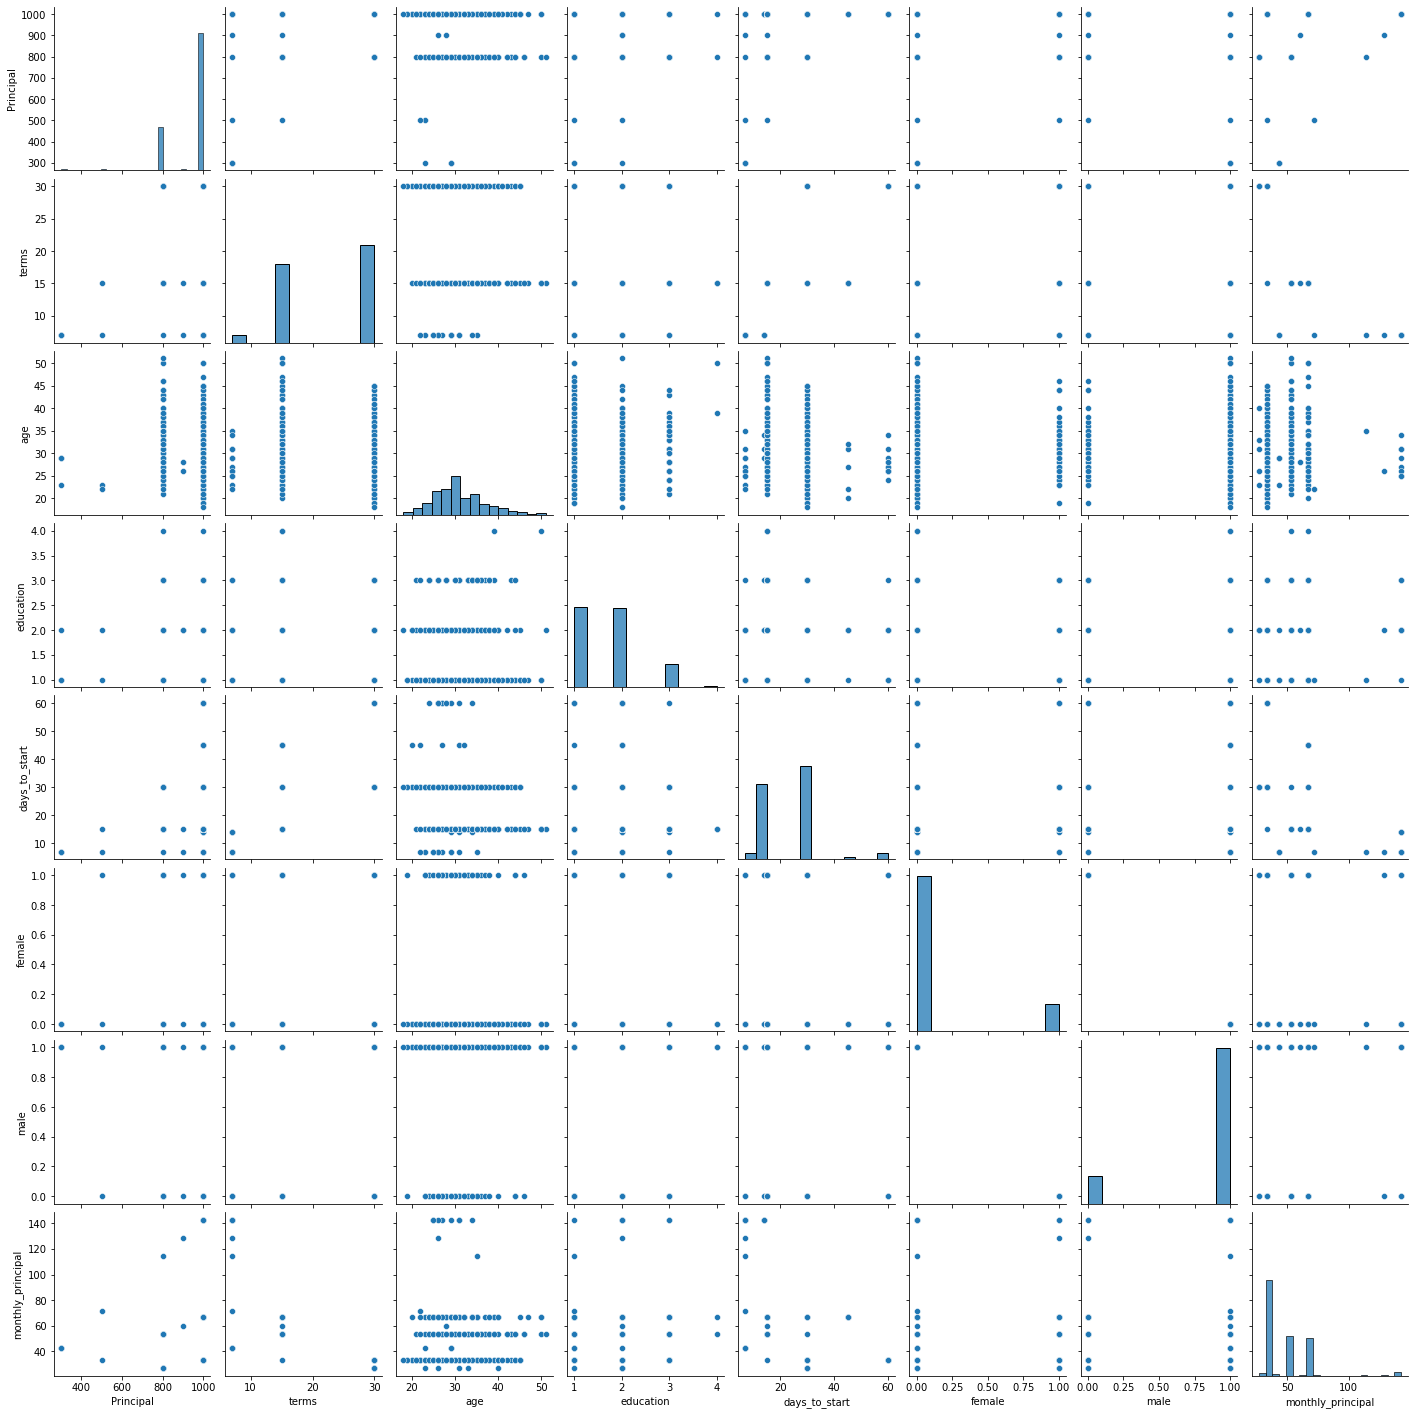

In [159]:
# Plot features against each other to view any relationships that may exist
sns.pairplot(loans)
plt.show()

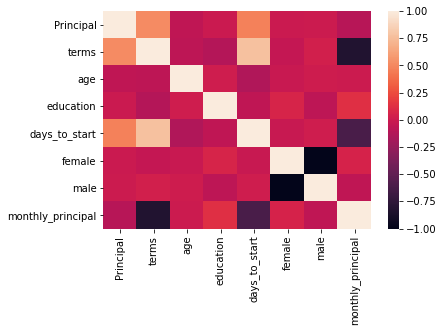

In [160]:
# Inspect correlations between features
sns.heatmap(loans.corr())
plt.show()

## 3. Data Preparation

After analyzing the data for cleanup, performing feature engineering, and transforming features to numerical values, we can now prepare the data for modeling

## 4. Modeling

## 5. Evaluation